In [1]:
# standard library imports
import re
import pickle

# third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# custom imports
from pprint import pprint
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from category_encoders.one_hot import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from statistics import mean

In [2]:
dataset = pd.read_csv("../data/data_enriched.csv")

In [3]:
data_copy = dataset.copy()

In [4]:
dataset.head()

,car_color,fuel_type,car_type,car_license,gear_type,windows,motor_power,speedometer,passengers_number,payment_method,car_state,ex_owners,additions,price
0,أبيض عاجي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,2000,75000.0,5.0,نقدا فقط,للبيع فقط,1.0,\n\nمُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\n...,100000
1,سكني,ديزل,خصوصي,فلسطينية,نصف اوتوماتيك,الكتروني,2500,130000.0,8.0,إمكانية التقسيط,للبيع أو التبديل,2.0,\n\nمُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\n...,60000
2,سكني,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1600,NaN,NaN,نقدا فقط,للبيع فقط,NaN,\n\nمُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\n...,43500
3,بيج,بنزين,خصوصي,فلسطينية,عادي,يدوي,906,NaN,5.0,إمكانية التقسيط,للبيع فقط,0.0,\n\nمُكيّف\nمسجل CD\n\n,5500
4,فضي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1200,38000.0,5.0,نقدا فقط,للبيع فقط,NaN,\n\nمُكيّف\nإغلاق مركزي\nجهاز إنذار\nجنطات مغن...,54000


In [5]:
dataset.shape

(6864, 14)

## Feature Engineering

#### Feature Selection

In [6]:
dataset.drop(['additions'], axis=1, inplace=True) 

### Handle outliers

In [7]:
def handle_outliers(data, feature):
    """handle outliers

    Args:
        data (DataFrame): dataset
        feature (Series): feature with outliers needed to be handled

    Returns:
        DataFrame: dataset after removing outliers
    """
    upper_lim = data[feature].quantile(.999)
    lower_lim = data[feature].quantile(.0000001)

    return data[(data[feature] < upper_lim) & (data[feature] > lower_lim)]

In [8]:
dataset = handle_outliers(dataset, 'speedometer')

In [9]:
dataset.shape

(4357, 13)

#### Split data into features and target variable

In [10]:
X = dataset.drop(columns = 'price')
y = dataset['price'] 

#### Feature Preprocessing Transformation
###### transform features applying ColumnTransformer() pipeline

In [11]:
# get categorical features
categorical_features = dataset.select_dtypes(['object']).columns.to_list()

In [12]:
# get numeric features
numeric_features = X.select_dtypes('number').columns.to_list()

In [13]:
# Utilize Pipeline to perform different preprocessing steps to numerical columns of the data
num_pipeline = Pipeline([
    # Handle missing data using KNNImputer
    ('imputer', KNNImputer(n_neighbors=3)),
    # Perform feature scaling on numeric attributes using log transformation
    ('log_transformer', PowerTransformer()),
    ])

In [14]:
# Apply different preprocessing steps to different columns of the data
transformer = ColumnTransformer(
    transformers = [  
        # Perform One-Hot encoding on the categorical attributes
        ('categorical', OneHotEncoder(), categorical_features),
        # Perform the numerical pipeline on numeric attributes
        ('numerical', num_pipeline, numeric_features),
    ],
    remainder='passthrough'
    )

In [15]:
# Transform dataset to feed the ML Algorithm
X_transformed = transformer.fit_transform(X)

c:\Users\DELL\Study\ML2 2022\ML2 Assignment1 Car Price Prediction\car-price-prediction\venv_car_price_pred\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
c:\Users\DELL\Study\ML2 2022\ML2 Assignment1 Car Price Prediction\car-price-prediction\venv_car_price_pred\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
c:\Users\DELL\Study\ML2 2022\ML2 Assignment1 Car Price Prediction\car-price-prediction\venv_car_price_pred\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
c:\Users\DELL\Study\ML2 2022\ML2 Assignment1 Car Price Prediction\car-price-predictio

In [16]:
X_transformed

array([[ 1.        ,  0.        ,  0.        , ...,  0.21054285,
        -0.17134673, -0.49311222],
       [ 0.        ,  1.        ,  0.        , ...,  0.4387408 ,
         2.47390984,  0.26810668],
       [ 0.        ,  0.        ,  1.        , ..., -0.06096995,
        -0.17134673, -0.49311222],
       ...,
       [ 0.        ,  0.        ,  1.        , ...,  0.04724654,
        -0.17134673, -1.78947274],
       [ 0.        ,  0.        ,  0.        , ..., -2.00076915,
         1.71416546,  0.26810668],
       [ 0.        ,  0.        ,  0.        , ...,  2.39795379,
         2.47390984,  1.57439135]])

#### Define models to train/test the data on

In [17]:
models = {'ordinary_least_squares_model': {'model': LinearRegression(), 
                  'description': 'orinary least square'
                  },
        'stochastic_gradient_descent_1000_iterations': {'model': SGDRegressor(),
                  'description': 'gradient descent with 1000 iteration'
                  },
        'stochastic_gradient_descent_10_iterations': {'model': SGDRegressor(max_iter=10),
                  'description': 'gradient descent with 10 iteration'
                  },
        'polynomial_degree_2': {'model': LinearRegression(),
                  'degree': 2,
                  'description': 'Polynomial with 2 degree'
                  },
        'polynomial_degree_2_ridge': {'model': Ridge(),
                  'degree': 2,
                  'description': 'orinary least square'
                  },
        'polynomial_degree_2_lasso': {'model': Lasso(),
                  'degree': 2,
                  'description': 'orinary least square'
                  },
        '3nn': {'model': KNeighborsClassifier(n_neighbors=3),
                  'description': 'KNN with k=3'
                  },
        'decision_tree': {'model': DecisionTreeRegressor(),
                  'description': 'Decision Tree Regressor'
                  },
        "random_forest_regressor": {"model": RandomForestRegressor(),
                  "description":"Random Forest Regressor"
                  },
        "random_forest_regressor_n_estimators_15": {"model": RandomForestRegressor(n_estimators = 15),
                  "description":"Random Forest Regressor with n_estimators hyperparameter = 15"
                  },
        'gradient_boosting_regressor': {'model': GradientBoostingRegressor(),
                  'description': 'Gradient Boosting Regressor'
                  },
        'gradient_boosting_regressor_n_estimators_15': {'model': GradientBoostingRegressor(n_estimators = 15),
                  'description': 'Gradient Boosting Regressor with n_estimators hyperparameter = 15'
                  }
  }

#### Define funcitons needed to train, predict, and evaluate the data

In [18]:
def train_plynomial_model(model, degree, X_train, y_train):
    """train polynomial model with the given degree

    Args:
        model (sklearn model): model to fit polynomial degree on to become a polynomial model
        degree (int): degree of polynomial model
        X_train (ndarray): features
        y_train (ndarray): target variable
    """
    poly = PolynomialFeatures(degree)
    poly_x_train = poly.fit_transform(X_train)
    model.fit(poly_x_train, y_train)

In [19]:
def train_model(models, X_train, y_train):
    """ train models by fitting each model on training dataset

    Args:
        models (Dict): dictionary of models to be evaluated
        X_train (ndarray): features
        y_train (ndarray): target variable

    Returns:
        Dict: models dictionary adjusted after fitting each model with training data
    """
    # go over all models
    for model_id in models:
        # train if polynomial
        if models[model_id].get("degree"):
            train_plynomial_model(models[model_id]['model'],\
                                  models[model_id]['degree'],\
                                  X_train,\
                                  y_train)
            
        else:  
            models[model_id]['model'].fit(X_train, y_train)
        #print(models[model_id]['model'].coef_)
        #print(models[model_id]['model'].intercept_)
        
    # return the new dictionary
    return models

In [20]:
def predict_plynomial_model(model, degree, X_test):
    """ predict polynomial model with specific degree

    Args:
        model (sklearn model): model to fit polynomial degree on to become a polynomial model
        degree (int): degree of polynomial model
        X_test (ndarray): features

    Returns:
        ndarray: polynomial predicted values for X_test data
    """
    poly = PolynomialFeatures(degree)
    poly_x_test = poly.fit_transform(X_test)   
    return model.predict(poly_x_test)

In [21]:
def eval_models(models, X_test, y_test, train_or_test):
    """ Evaluate the data despite it's training set or test set using r2 and RMSE evaluation metrics 
    and add the score for each model to the dictionary

    Args:
        models (Dict): dictionary of models to be evaluated
        X_test (ndarray): features
        y_test (ndarray): target variable
        train_or_test (str): whether the data is a training set or testing set

    Returns:
        Dict: models dictionary adjusted with added evaluation score
    """
    # go over all models
    for model_id in models:
        # predict models

        # in case the model have a "degree", then it's a polynomial model. Call the funciton that predict the polynomial model
        if models[model_id].get("degree"):
            y_predict= predict_plynomial_model(models[model_id]['model'],\
                                  models[model_id]['degree'],\
                                  X_test)
            
        else: 
            y_predict = models[model_id]['model'].predict(X_test)

        # evaluate models using 'Root Mean Square Error' evaluation metric
        rmse = mean_squared_error(y_test, y_predict, squared=False)
        models[model_id][f'{train_or_test}_RMSE'] = rmse
        
        # evaluate models dataset using 'R square' evaluation metric
        models[model_id][f'{train_or_test}_R2_score'] = r2_score(y_test, y_predict)

    # return models dictionary adjusted attached with evaluation metric
    return models

Split the data

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
                            X_transformed, y,
                            test_size=.25, random_state=42
                            )

In [23]:
y_train.shape

(3267,)

In [24]:
y_test.shape

(1090,)

In [25]:
train_model(models, X_train, y_train)

c:\Users\DELL\Study\ML2 2022\ML2 Assignment1 Car Price Prediction\car-price-prediction\venv_car_price_pred\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\DELL\Study\ML2 2022\ML2 Assignment1 Car Price Prediction\car-price-prediction\venv_car_price_pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.255e+12, tolerance: 1.110e+09
  model = cd_fast.enet_coordinate_descent(


{'ordinary_least_squares_model': {'model': LinearRegression(),
  'description': 'orinary least square'},
 'stochastic_gradient_descent_1000_iterations': {'model': SGDRegressor(),
  'description': 'gradient descent with 1000 iteration'},
 'stochastic_gradient_descent_10_iterations': {'model': SGDRegressor(max_iter=10),
  'description': 'gradient descent with 10 iteration'},
 'polynomial_degree_2': {'model': LinearRegression(),
  'degree': 2,
  'description': 'Polynomial with 2 degree'},
 'polynomial_degree_2_ridge': {'model': Ridge(),
  'degree': 2,
  'description': 'orinary least square'},
 'polynomial_degree_2_lasso': {'model': Lasso(),
  'degree': 2,
  'description': 'orinary least square'},
 '3nn': {'model': KNeighborsClassifier(n_neighbors=3),
  'description': 'KNN with k=3'},
 'decision_tree': {'model': DecisionTreeRegressor(),
  'description': 'Decision Tree Regressor'},
 'random_forest_regressor': {'model': RandomForestRegressor(),
  'description': 'Random Forest Regressor'},
 '

In [26]:
eval_models(models, X_test, y_test, 'test')

{'ordinary_least_squares_model': {'model': LinearRegression(),
  'description': 'orinary least square',
  'test_RMSE': 53607.979826906536,
  'test_R2_score': 0.21054474722831862},
 'stochastic_gradient_descent_1000_iterations': {'model': SGDRegressor(),
  'description': 'gradient descent with 1000 iteration',
  'test_RMSE': 53656.06994505185,
  'test_R2_score': 0.20912771845270584},
 'stochastic_gradient_descent_10_iterations': {'model': SGDRegressor(max_iter=10),
  'description': 'gradient descent with 10 iteration',
  'test_RMSE': 53624.47601059299,
  'test_R2_score': 0.21005881201438736},
 'polynomial_degree_2': {'model': LinearRegression(),
  'degree': 2,
  'description': 'Polynomial with 2 degree',
  'test_RMSE': 3049744749431086.0,
  'test_R2_score': -2.555027743838248e+21},
 'polynomial_degree_2_ridge': {'model': Ridge(),
  'degree': 2,
  'description': 'orinary least square',
  'test_RMSE': 55051.40658450076,
  'test_R2_score': 0.16745929697242412},
 'polynomial_degree_2_lasso'

In [27]:
eval_models(models, X_train, y_train, 'train')

{'ordinary_least_squares_model': {'model': LinearRegression(),
  'description': 'orinary least square',
  'test_RMSE': 53607.979826906536,
  'test_R2_score': 0.21054474722831862,
  'train_RMSE': 49712.59057086342,
  'train_R2_score': 0.27241796462933976},
 'stochastic_gradient_descent_1000_iterations': {'model': SGDRegressor(),
  'description': 'gradient descent with 1000 iteration',
  'test_RMSE': 53656.06994505185,
  'test_R2_score': 0.20912771845270584,
  'train_RMSE': 49867.26197664983,
  'train_R2_score': 0.26788345124001056},
 'stochastic_gradient_descent_10_iterations': {'model': SGDRegressor(max_iter=10),
  'description': 'gradient descent with 10 iteration',
  'test_RMSE': 53624.47601059299,
  'test_R2_score': 0.21005881201438736,
  'train_RMSE': 50081.44186464872,
  'train_R2_score': 0.26158106477848886},
 'polynomial_degree_2': {'model': LinearRegression(),
  'degree': 2,
  'description': 'Polynomial with 2 degree',
  'test_RMSE': 3049744749431086.0,
  'test_R2_score': -2.55

In [28]:
# Observe scores in a neat way
pd.DataFrame.from_dict(models,orient='index')

,model,description,test_RMSE,test_R2_score,train_RMSE,train_R2_score,degree
ordinary_least_squares_model,LinearRegression(),orinary least square,5.360798e+04,2.105447e-01,49712.590571,0.272418,NaN
stochastic_gradient_descent_1000_iterations,SGDRegressor(),gradient descent with 1000 iteration,5.365607e+04,2.091277e-01,49867.261977,0.267883,NaN
stochastic_gradient_descent_10_iterations,SGDRegressor(max_iter=10),gradient descent with 10 iteration,5.362448e+04,2.100588e-01,50081.441865,0.261581,NaN
polynomial_degree_2,LinearRegression(),Polynomial with 2 degree,3.049745e+15,-2.555028e+21,43746.091409,0.436586,2.0
polynomial_degree_2_ridge,Ridge(),orinary least square,5.505141e+04,1.674593e-01,44124.044293,0.426808,2.0
polynomial_degree_2_lasso,Lasso(),orinary least square,5.718798e+04,1.015828e-01,43729.911596,0.437003,2.0
3nn,KNeighborsClassifier(n_neighbors=3),KNN with k=3,5.828908e+04,6.665327e-02,53509.014307,0.157048,NaN
decision_tree,DecisionTreeRegressor(),Decision Tree Regressor,7.313888e+04,-4.694855e-01,1796.390542,0.999050,NaN
random_forest_regressor,"(DecisionTreeRegressor(max_features=1.0, rando...",Random Forest Regressor,5.393937e+04,2.007541e-01,17943.904509,0.905206,NaN
random_forest_regressor_n_estimators_15,"(DecisionTreeRegressor(max_features=1.0, rando...",Random Forest Regressor with n_estimators hype...,5.396574e+04,1.999724e-01,21277.219267,0.866716,NaN


In [29]:
def models_evaluation_test_train(models):
    """Present Model name, R2 train score, and R2 test score for each model neatly

    Args:
        models (Dict): dictionary of models trained and evaluated, along with 
                a description for each model and its train score and test score
    """
    for model in models:
        print(model)
        print(f"train_R2_score = {models[model]['train_R2_score']}")
        print(f"test_R2_score = {models[model]['test_R2_score']}")
        print('-' * 100)
        

In [30]:
models_evaluation_test_train(models)

ordinary_least_squares_model
train_R2_score = 0.27241796462933976
test_R2_score = 0.21054474722831862
----------------------------------------------------------------------------------------------------
stochastic_gradient_descent_1000_iterations
train_R2_score = 0.26788345124001056
test_R2_score = 0.20912771845270584
----------------------------------------------------------------------------------------------------
stochastic_gradient_descent_10_iterations
train_R2_score = 0.26158106477848886
test_R2_score = 0.21005881201438736
----------------------------------------------------------------------------------------------------
polynomial_degree_2
train_R2_score = 0.436585928916417
test_R2_score = -2.555027743838248e+21
----------------------------------------------------------------------------------------------------
polynomial_degree_2_ridge
train_R2_score = 0.42680842188609913
test_R2_score = 0.16745929697242412
---------------------------------------------------------------------

* Observe overfitting in Decision Tree
* GradientBoostingRegressor() scored the highest. Then tune its hyperparameters to get better score

### Hyper Parameter Tuning

##### Show GradientBoostingRegressor() parameters to choose which to tune 

In [31]:
gradient_boosting = GradientBoostingRegressor(random_state=42)
gradient_boosting.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

#### Define parameter distribution  for GBT
##### Set up the parameter distribution for the random search

In [32]:
# Number of trees in Gradient Boosting Trees 
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 74, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10, 16]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 7]
# Method of selecting samples for training each tree
learning_rate = [0.01, 0.1]

# Create the distribution of the hyperparameters (param_distribs)
parameter_distribution = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': learning_rate}
pprint(parameter_distribution)

{'learning_rate': [0.01, 0.1],
 'max_depth': [5, 12, 20, 28, 35, 43, 51, 58, 66, 74, None],
 'min_samples_leaf': [2, 4, 7],
 'min_samples_split': [5, 10, 16],
 'n_estimators': [100, 200, 300, 400, 500]}


#### Create the random search object with desired options for best hyperparameters

* 5 fold cross validation
* Search across 10 different combinations
* Use all available cores
* R Squared evaluation metric

In [33]:
gbt_random_search = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(), # the base model
    param_distributions=parameter_distribution, # the distribution of the hyperparameters 
    n_iter=10,  # Number of parameter combinations to try
    cv=5,  # Number of folds for cross-validation
    scoring='r2',  # Evaluation metric
    verbose=2,  # print some logs while evaluating the different combinations
    random_state=42,  # Random seed for reproducibility
    n_jobs = 1 # use all cores in the machine to train (parallel)
)

##### Fit the random search object to the training data

In [34]:
gbt_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END learning_rate=0.01, max_depth=35, min_samples_leaf=7, min_samples_split=5, n_estimators=400; total time=   5.8s
[CV] END learning_rate=0.01, max_depth=35, min_samples_leaf=7, min_samples_split=5, n_estimators=400; total time=   6.1s
[CV] END learning_rate=0.01, max_depth=35, min_samples_leaf=7, min_samples_split=5, n_estimators=400; total time=   5.6s
[CV] END learning_rate=0.01, max_depth=35, min_samples_leaf=7, min_samples_split=5, n_estimators=400; total time=   6.0s
[CV] END learning_rate=0.01, max_depth=35, min_samples_leaf=7, min_samples_split=5, n_estimators=400; total time=   5.4s
[CV] END learning_rate=0.01, max_depth=58, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   2.4s
[CV] END learning_rate=0.01, max_depth=58, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   2.4s
[CV] END learning_rate=0.01, max_depth=58, min_samples_leaf=4, min_samples_split=5, n_estima

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=1,
                   param_distributions={'learning_rate': [0.01, 0.1],
                                        'max_depth': [5, 12, 20, 28, 35, 43, 51,
                                                      58, 66, 74, None],
                                        'min_samples_leaf': [2, 4, 7],
                                        'min_samples_split': [5, 10, 16],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, scoring='r2', verbose=2)

In [72]:
pickle.dump(gbt_random_search,
            open('../pkls/gbt_random_search_fit_train_data.pkl',
            'wb'))

In [36]:
# Get the best hyperparameters from the search
gbt_best_params = gbt_random_search.best_params_
gbt_best_params

{'n_estimators': 100,
 'min_samples_split': 16,
 'min_samples_leaf': 7,
 'max_depth': 5,
 'learning_rate': 0.1}

In [37]:
# Get the best score from the random search
gbt_random_search.best_score_

0.3413969691618899

In [38]:
cross_validation_scores = {}

In [39]:
cross_validation_scores['Best score for RandomSearch on GradientBoostingRegressor() model = '] = gbt_random_search.best_score_

#### Get the model with the best hyper parameters and observe its score

In [40]:
best_gbt_model = gbt_random_search.best_estimator_
best_gbt_model

GradientBoostingRegressor(max_depth=5, min_samples_leaf=7, min_samples_split=16)

In [41]:
best_gbt_model.score(X_test, y_test)

0.3189285305460693

* gbt_random_search scored higher than best_gbt_model

In [42]:
cross_validation_scores['test score for {best_estimator_} resulted from RandomSearch on GradientBoostingRegressor() model = '] = best_gbt_model.score(X_test, y_test)

#### Feature Importances

In [85]:
feature_importances = gbt_random_search.best_estimator_.feature_importances_

In [86]:
attributes = list(dataset.columns)[:-1]

In [87]:
sorted(zip(feature_importances, attributes), reverse=True)

[(0.016295561748311243, 'motor_power'),
 (0.012452004980502265, 'gear_type'),
 (0.009420573451149068, 'fuel_type'),
 (0.0057867895087982905, 'passengers_number'),
 (0.004559635664699894, 'car_state'),
 (0.004517095733415468, 'car_type'),
 (0.0022111437610064016, 'car_color'),
 (0.0012186634838928705, 'payment_method'),
 (0.00038917304247664745, 'car_license'),
 (0.00030539455584554696, 'windows'),
 (0.0002859813194118216, 'ex_owners'),
 (0.00017194851024866876, 'speedometer')]

* Observe that 'motor_power' scored the highest
* and 'speedometer' scored the lowest

#### Use the best hyperparameters to create a new model to make predictions

In [43]:
best_model_gbt = GradientBoostingRegressor(**gbt_best_params)

#### Create model pipeline to utilize it in microservice for prediction

In [44]:
pipeline = Pipeline(
    steps = [
        ("transformer", transformer),
        ("model", best_model_gbt)
    ]
)

In [45]:
# fit the pipeline on the whole dataset
pipeline.fit(X, y) 

c:\Users\DELL\Study\ML2 2022\ML2 Assignment1 Car Price Prediction\car-price-prediction\venv_car_price_pred\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
c:\Users\DELL\Study\ML2 2022\ML2 Assignment1 Car Price Prediction\car-price-prediction\venv_car_price_pred\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
c:\Users\DELL\Study\ML2 2022\ML2 Assignment1 Car Price Prediction\car-price-prediction\venv_car_price_pred\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
c:\Users\DELL\Study\ML2 2022\ML2 Assignment1 Car Price Prediction\car-price-predictio

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(),
                                                  ['car_color', 'fuel_type',
                                                   'car_type', 'car_license',
                                                   'gear_type', 'windows',
                                                   'payment_method',
                                                   'car_state']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=3)),
                                                                  ('log_transformer',
                                                                   PowerTransformer())]),
                                                  ['motor_power', 'speedometer',
                                                   'passengers_number',
                                                   'ex_owners'])])),
                ('model',
                 GradientBoostingRegressor(max_depth=5, min_samples_leaf=7,
                                           min_samples_split=16))])

In [71]:
pickle.dump(pipeline,
            open('../pkls/best_model_gbt_random_search.pkl',
            'wb'))

### Cross Validation

##### Cross Validaiton on GradientBoostingRegressor() with best hyperparameters resulted from Random Search hyperparameters tuning

In [47]:
scores_best_model_gbt_cv = cross_val_score(best_model_gbt, X_transformed, y, cv=10, scoring='r2')

In [48]:
print(scores_best_model_gbt_cv.mean())
print(scores_best_model_gbt_cv.max())

0.35456951474838494
0.611569301864878


In [49]:
cross_validation_scores['mean score for Gradient Boosting with best hyperparameters \
    resulted from Random Search = '] = scores_best_model_gbt_cv.mean()
cross_validation_scores['max score for Gradient Boosting with best hyperparameters \
    resulted from Random Search = '] = scores_best_model_gbt_cv.max()

##### Cross Validaiton on base GradientBoostingRegressor() without choosing hyperparameters

In [50]:
base_gbt = GradientBoostingRegressor(random_state = 42)

In [51]:
# it will return the 10 testing r2 scores as a numpy array
scores_base_gbt = cross_val_score(base_gbt, X_transformed, y, cv=10, scoring='r2')

In [52]:
# use average as an estimate of out-of-sample score
print(scores_base_gbt.mean())
print(scores_base_gbt.max())

0.32901734787635684
0.5646669707841343


In [53]:
cross_validation_scores['mean score 10 folds cross validation Base Gradient \
    Boosting without Hyperparameters = '] = scores_base_gbt.mean()
cross_validation_scores['max score 10 folds cross validation Base Gradient \
    Boosting without Hyperparameters = '] = scores_base_gbt.max()

In [54]:
def get_cross_validation_scores_given_hyperparameter(hyperparameter_values):
    """Apply cross validation on different values of a hyperparameter and observe their mean score

    Args:
        hyperparameter_values (list): various values of a hyperparameter 

    Returns:
        list: list of mean scores for applying cross validation on each value of the hyperparameter
    """
    # empty list to store scores
    n_scores = []

    # 1. loop through reasonable values of hyperparameter_values
    for hyperparameter_value in hyperparameter_values:
        # 2. run GradientBoostingRegressor with hyperparameter_value
        gbt = GradientBoostingRegressor(n_estimators = hyperparameter_value, random_state = 42)
        # 3. obtain cross_val_score for GradientBoostingRegressor with hyperparameter_value
        scores = cross_val_score(gbt, X_transformed, y, cv=10, scoring='r2')
        # 4. append mean of scores for hyperparameter_value to n_scores list
        n_scores.append(scores.mean())
    
    return n_scores

In [55]:
def plot_cross_validation_scores(x_axis_hyperparameter, n_scores, x_label):
    """plot how score changes as we vary in x-axis, 
    plot each value of the hyperparameter (x-axis) versus the cross-validated r2 score (y-axis)

    Args:
        x_axis_hyperparameter (list): list of different values of the hyperparameter
        n_scores (list): list of cross-validation scores for each value of the hyperparameter
        x_label (str): description of the x-axis to label
    """
    plt.plot(x_axis_hyperparameter, n_scores)
    plt.xlabel(f'Value of {x_label}')
    plt.ylabel('Cross-validated score')

#### Cross validation on different values of {n_estimators} hyperparameter

In [56]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]

n_scores_for_n_estimators_hyperparameter = get_cross_validation_scores_given_hyperparameter(n_estimators)

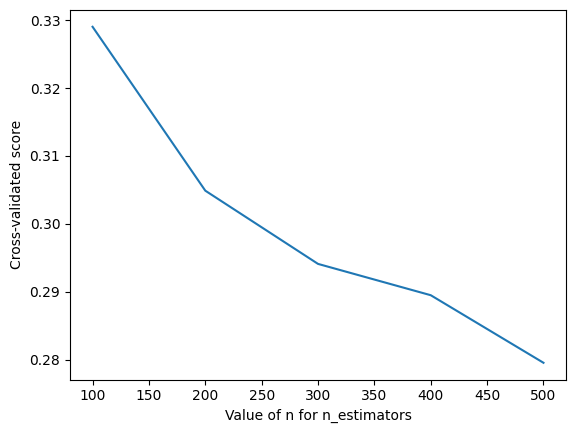

In [57]:
plot_cross_validation_scores(
    n_estimators, 
    n_scores_for_n_estimators_hyperparameter, 
    'n for n_estimators')

In [58]:
print('Highest score = ', max(n_scores_for_n_estimators_hyperparameter))
print('Avg score = ', mean(n_scores_for_n_estimators_hyperparameter))

Highest score =  0.32901734787635684
Avg score =  0.29941603842795744


In [59]:
cross_validation_scores['mean score 10 folds cross validation Gradient Boosting with 5 different\
     values of mean cross validation for 5 different values of estimators hyperparameter = '] = \
     mean(n_scores_for_n_estimators_hyperparameter)
cross_validation_scores['max score 10 folds cross validation Gradient Boosting with 5 different \
    values of mean cross validation for 5 different values of estimators hyperparameter = '] = \
    max(n_scores_for_n_estimators_hyperparameter)

#### Cross Validation with another different values of n_estimators

In [60]:
# Number of trees in Gradient Boosting Trees 
n_estimators = [10,20,50,100,200,300,400]

n_scores_for_n_estimators_hyperparameter = get_cross_validation_scores_given_hyperparameter(n_estimators)

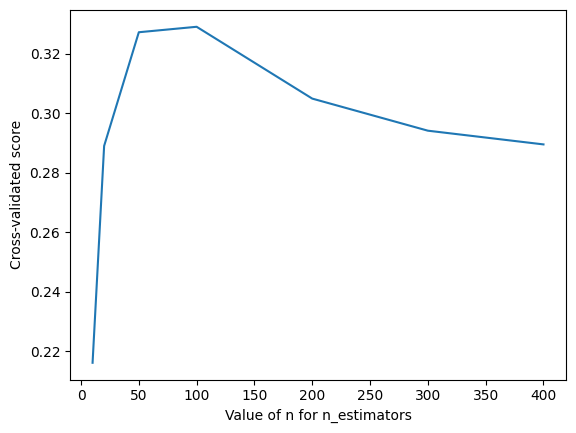

In [61]:
plot_cross_validation_scores(
    n_estimators, 
    n_scores_for_n_estimators_hyperparameter, 
    'n for n_estimators')

In [62]:
print('Highest score = ', max(n_scores_for_n_estimators_hyperparameter))
print('Avg score = ', mean(n_scores_for_n_estimators_hyperparameter))

Highest score =  0.32901734787635684
Avg score =  0.292835645623801


In [63]:
cross_validation_scores['mean score 10 folds cross validation Gradient Boosting with 7 different \
    values of mean cross validation for 7 different values of estimators hyperparameter = '] = \
        mean(n_scores_for_n_estimators_hyperparameter)
cross_validation_scores['max score 10 folds cross validation Gradient Boosting with 7 different \
    values of mean cross validation for 7 different values of estimators hyperparameter = '] = \
        max(n_scores_for_n_estimators_hyperparameter)

#### Cross Validation with different values of max_depth hyperparameter

In [64]:
# maximum depth in Gradient Boosting Trees 
max_depth = [int(x) for x in np.linspace(5, 74, num = 10)]

n_scores_for_max_depth_hyperparameter = get_cross_validation_scores_given_hyperparameter(max_depth)

In [65]:
n_scores_for_max_depth_hyperparameter

[0.14700345052267488,
 0.2391531684593354,
 0.2889987313819401,
 0.3100182249817379,
 0.31822806872930326,
 0.323630493355918,
 0.3280364207705121,
 0.3296322344385708,
 0.3331381796281741,
 0.3326348363302203]

In [66]:
print('Highest score = ', max(n_scores_for_max_depth_hyperparameter))
print('Avg score = ', mean(n_scores_for_max_depth_hyperparameter))

Highest score =  0.3331381796281741
Avg score =  0.29504738085983867


In [67]:
cross_validation_scores['mean score 10 folds cross validation Gradient Boosting with 10 different \
    values of mean cross validation for 10 different values of max_depth hyperparameter = '] = \
        mean(n_scores_for_max_depth_hyperparameter)
cross_validation_scores['max score 10 folds cross validation Gradient Boosting with 10 different \
    values of mean cross validation for 10 different values of max_depth hyperparameter = '] = \
        max(n_scores_for_max_depth_hyperparameter)

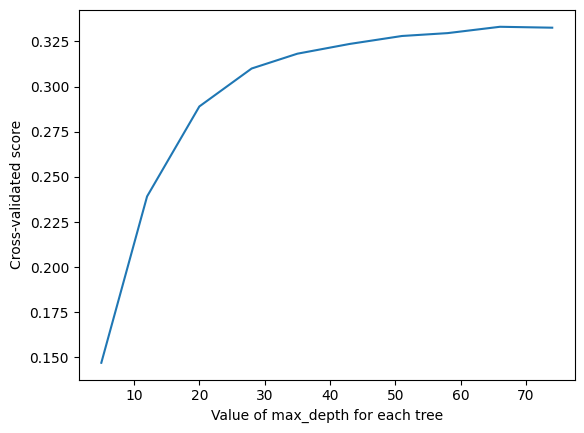

In [68]:
plot_cross_validation_scores(
    max_depth, 
    n_scores_for_max_depth_hyperparameter, 
    'max_depth for each tree')

In [70]:
# Observe resulted mean scores of cross vallidation from different hyperparameters values
for description, score in cross_validation_scores.items():
    print(f'{score}\t{description}')


0.3413969691618899 	= Best score for RandomSearch on GradientBoostingRegressor() model = 
0.3189285305460693 	= test score for {best_estimator_} resulted from RandomSearch on GradientBoostingRegressor() model = 
0.35456951474838494 	= mean score for Gradient Boosting with best hyperparameters     resulted from Random Search = 
0.611569301864878 	= max score for Gradient Boosting with best hyperparameters     resulted from Random Search = 
0.32901734787635684 	= mean score 10 folds cross validation Base Gradient     Boosting without Hyperparameters = 
0.5646669707841343 	= max score 10 folds cross validation Base Gradient     Boosting without Hyperparameters = 
0.29941603842795744 	= mean score 10 folds cross validation Gradient Boosting with 5 different     values of mean cross validation for 5 different values of estimators hyperparameter = 
0.32901734787635684 	= max score 10 folds cross validation Gradient Boosting with 5 different     values of mean cross validation for 5 different

* Observe that the lowest score = mean score 10 folds cross validation Gradient Boosting with 7 different values of mean cross validation for 7 different values of estimators hyperparameter
* Obeserve that (mean cross validation score for Gradient Boosting with best hyperparameters resulted from Random Search ) is the highest